<a href="https://colab.research.google.com/github/alastra32/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

#I'd like to see more pandas, scikit-learn, libraries for doing data scrapping and visualizations such as Plotly and bokeh.

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

#2018 FIFA World Cup Data

##Loading Data and Libraries

In [6]:
# TODO - your code here
# Use what we did live in lecture as an example

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

worldcup = pd.read_csv('2018FIFAWorldCupSquads.csv') #world cup squads

worldcup.head()

,Team,Group,Squad Number,Position,Player,Date Of Birth,Age,Caps,Goals,Club,Player Count
0,Egypt,A,1,GK,Essam El-Hadary (captain),1973/01/15,45,157,0,Al-Taawoun,1
1,Egypt,A,2,DF,Ali Gabr,1989/01/01,29,20,1,West Bromwich Albion,1
2,Egypt,A,3,DF,Ahmed Elmohamady,1987/09/09,30,77,2,Aston Villa,1
3,Egypt,A,4,MF,Omar Gaber,1992/01/30,26,23,0,Los Angeles FC,1
4,Egypt,A,5,MF,Sam Morsy,1991/09/10,26,4,0,Wigan Athletic,1


In [7]:
print(worldcup.shape)

(736, 11)


In [15]:
fifa18 = pd.read_csv('FIFA18.csv') #FIFA 18

fifa18.head()

,ID,name,full_name,club,special,age,league,birth_date,height_cm,weight_kg,body_type,real_face,nationality,eur_value,eur_wage,eur_release_clause,overall,potential,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,work_rate_att,work_rate_def,preferred_foot
0,20801,Cristiano Ronaldo,C. Ronaldo dos Santos Aveiro,Real Madrid CF,2228.0,32.0,Spanish Primera División,2/5/1985,185.0,80.0,C. Ronaldo,True,Portugal,95500000.0,565000.0,195800000.0,94.0,94.0,90.0,93.0,82.0,90.0,33.0,80.0,5.0,5.0,4.0,High,Low,Right
1,158023,L. Messi,Lionel Messi,FC Barcelona,2158.0,30.0,Spanish Primera División,6/24/1987,170.0,72.0,Messi,True,Argentina,105000000.0,565000.0,215300000.0,93.0,93.0,89.0,90.0,86.0,96.0,26.0,61.0,5.0,4.0,4.0,Medium,Medium,Left
2,190871,Neymar,Neymar da Silva Santos Jr.,Paris Saint-Germain,2100.0,25.0,French Ligue 1,2/5/1992,175.0,68.0,Neymar,True,Brazil,123000000.0,280000.0,236800000.0,92.0,94.0,92.0,84.0,79.0,95.0,30.0,60.0,5.0,5.0,5.0,High,Medium,Right
3,176580,L. Suárez,Luis Suárez,FC Barcelona,2291.0,30.0,Spanish Primera División,1/24/1987,182.0,86.0,Normal,True,Uruguay,97000000.0,510000.0,198900000.0,92.0,92.0,82.0,90.0,79.0,87.0,42.0,81.0,5.0,4.0,4.0,High,Medium,Right
4,167495,M. Neuer,Manuel Neuer,FC Bayern Munich,1493.0,31.0,German Bundesliga,3/27/1986,193.0,92.0,Normal,True,Germany,61000000.0,230000.0,100700000.0,92.0,92.0,91.0,90.0,95.0,89.0,60.0,91.0,5.0,1.0,4.0,Medium,Medium,Right


In [16]:
print(fifa18.shape)

(17012, 30)


## Data Exploration

In [5]:
worldcup.sort_values('Age', ascending= False).head(10)

,Team,Group,Squad Number,Position,Player,Date Of Birth,Age,Caps,Goals,Club,Player Count
0,Egypt,A,1,GK,Essam El-Hadary (captain),1973/01/15,45,157,0,Al-Taawoun,1
486,Mexico,F,4,DF,Rafael Márquez,1979/02/13,39,144,18,Atlas,1
187,Australia,C,4,FW,Tim Cahill,1979/12/06,38,105,50,Millwall,1
26,Russia,A,4,DF,Sergei Ignashevich,1979/07/14,38,121,8,CSKA Moscow,1
483,Mexico,F,1,GK,José de Jesús Corona,1981/01/26,37,52,0,Cruz Azul,1
620,Panama,G,23,DF,Felipe Baloy (captain),1981/02/24,37,102,3,Municipal,1
604,Panama,G,7,FW,Blas Pérez,1981/03/13,37,117,43,Municipal,1
195,Australia,C,12,GK,Brad Jones,1982/03/19,36,5,0,Feyenoord,1
615,Panama,G,18,FW,Luis Tejada,1982/03/28,36,105,43,Sport Boys,1
139,Portugal,B,2,DF,Bruno Alves,1981/11/27,36,95,11,Rangers,1


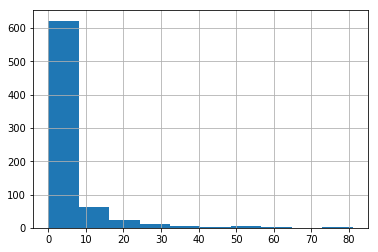

In [56]:
worldcup.Goals.hist()
plt.show()

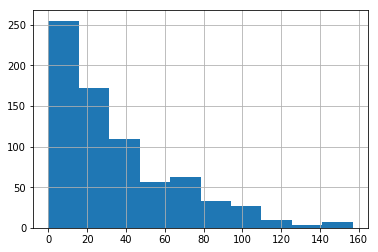

In [54]:
worldcup.Caps.hist()
plt.show()

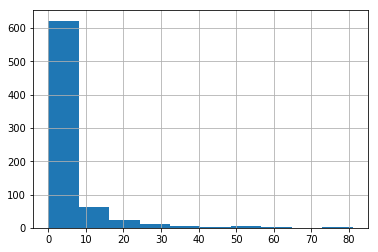

In [23]:
worldcup.Goals.hist()
plt.show()

In [19]:
worldcup.Club.value_counts()

Manchester City             16
Real Madrid                 15
Barcelona                   14
Paris Saint-Germain         12
Tottenham Hotspur           12
Bayern Munich               11
Juventus                    11
Chelsea                     11
Manchester United           11
Al-Hilal                     9
Atlético Madrid              9
Al-Ahli                      9
Leicester City               8
Monaco                       8
Arsenal                      7
Al Ahly                      7
Borussia Dortmund            7
Borussia Mönchengladbach     7
Liverpool                    7
Sporting CP                  7
Lokomotiv Moscow             6
Napoli                       6
Sevilla                      6
Eintracht Frankfurt          6
CSKA Moscow                  6
Zenit Saint Petersburg       6
Stoke City                   5
Porto                        5
Milan                        5
Feyenoord                    5
                            ..
Tianjin TEDA                 1
Wigan At

##Joining Another Dataset

In [27]:
df = pd.merge(worldcup, fifa18, how='left', left_on='Player', right_on='full_name')
df.head()

,Team,Group,Squad Number,Position,Player,Date Of Birth,Age,Caps,Goals,Club,Player Count,ID,name,full_name,club,special,age,league,birth_date,height_cm,weight_kg,body_type,real_face,nationality,eur_value,eur_wage,eur_release_clause,overall,potential,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,work_rate_att,work_rate_def,preferred_foot
0,Egypt,A,1,GK,Essam El-Hadary (captain),1973/01/15,45,157,0,Al-Taawoun,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Egypt,A,2,DF,Ali Gabr,1989/01/01,29,20,1,West Bromwich Albion,1,226077.0,A. Gabr,Ali Gabr,NaN,1498.0,30.0,NaN,1/10/1987,192.0,82.0,Normal,False,Egypt,0.0,0.0,NaN,67.0,67.0,63.0,35.0,46.0,45.0,68.0,72.0,1.0,2.0,2.0,Medium,Medium,Right
2,Egypt,A,3,DF,Ahmed Elmohamady,1987/09/09,30,77,2,Aston Villa,1,191005.0,A. Elmohamady,Ahmed Elmohamady,Aston Villa,2000.0,29.0,English Championship,9/9/1987,182.0,78.0,Lean,True,Egypt,2400000.0,24000.0,4500000.0,72.0,72.0,77.0,64.0,72.0,72.0,66.0,74.0,2.0,3.0,3.0,Medium,Medium,Right
3,Egypt,A,4,MF,Omar Gaber,1992/01/30,26,23,0,Los Angeles FC,1,212783.0,O. Gaber,Omar Gaber,FC Basel,1839.0,25.0,Swiss Super League,1/30/1992,174.0,71.0,Lean,False,Egypt,1200000.0,18000.0,1800000.0,69.0,74.0,76.0,57.0,65.0,67.0,65.0,74.0,1.0,2.0,3.0,Medium,High,Right
4,Egypt,A,5,MF,Sam Morsy,1991/09/10,26,4,0,Wigan Athletic,1,197975.0,S. Morsy,Sam Morsy,Wigan Athletic,1826.0,25.0,English League One,9/10/1991,175.0,76.0,Normal,False,Egypt,1100000.0,8000.0,2000000.0,68.0,71.0,66.0,56.0,63.0,70.0,60.0,76.0,1.0,3.0,3.0,Medium,Medium,Right


In [28]:
print(df.shape)

(740, 41)


##Analyzing the NAN values

In [29]:
df.isna().sum()

Team                          0
Group                         0
Squad Number                  0
Position                      0
Player                        0
Date Of Birth                 0
Age                           0
Caps                          0
Goals                         0
Club                          0
Player Count                  0
ID                          271
name                        271
full_name                   271
club                        292
special                     271
age                         271
league                      292
birth_date                  271
height_cm                   271
weight_kg                   271
body_type                   271
real_face                   271
nationality                 271
eur_value                   271
eur_wage                    271
eur_release_clause          322
overall                     271
potential                   271
pac                         271
sho                         271
pas     

In [30]:
df[df.ID.isna()]

,Team,Group,Squad Number,Position,Player,Date Of Birth,Age,Caps,Goals,Club,Player Count,ID,name,full_name,club,special,age,league,birth_date,height_cm,weight_kg,body_type,real_face,nationality,eur_value,eur_wage,eur_release_clause,overall,potential,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,work_rate_att,work_rate_def,preferred_foot
0,Egypt,A,1,GK,Essam El-Hadary (captain),1973/01/15,45,157,0,Al-Taawoun,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Egypt,A,6,DF,Ahmed Hegazi,1991/01/25,27,44,1,West Bromwich Albion,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Egypt,A,7,DF,Ahmed Fathy,1984/11/10,33,125,3,Al Ahly,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Egypt,A,11,FW,Kahraba,1994/04/13,24,18,3,Al-Ittihad,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Egypt,A,12,DF,Ayman Ashraf,1991/04/09,27,4,0,Al Ahly,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Egypt,A,13,DF,Mohamed Abdel-Shafy,1985/07/01,32,50,1,Al-Fateh,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Egypt,A,15,DF,Mahmoud Hamdy,1995/06/01,23,0,0,Zamalek,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,Egypt,A,18,FW,Shikabala,1986/03/05,32,29,2,Al-Raed,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Egypt,A,19,MF,Abdallah Said,1985/07/13,32,35,6,KuPS,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,Egypt,A,20,DF,Saad Samir,1989/04/01,29,11,0,Al Ahly,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
empty = df[df.ID.isna()]

In [36]:
empty.Team.value_counts()

South Korea     23
Brazil          22
Portugal        21
Spain           21
Saudi Arabia    20
Panama          15
Russia          14
Iran            14
Tunisia         12
Egypt           12
Costa Rica       9
Nigeria          9
Uruguay          8
Colombia         8
Morocco          8
Iceland          7
Senegal          7
Croatia          5
Serbia           5
Mexico           4
Peru             4
Australia        4
Switzerland      4
Belgium          3
Poland           2
Denmark          2
France           2
Japan            2
Sweden           1
Argentina        1
England          1
Germany          1
Name: Team, dtype: int64

###Too many NANs to use the stats from FIFA therefore moving forward the World Cup Dataset itself.

##Back to Analyzing the World Cup Dataset

In [39]:
type(worldcup['Date Of Birth'][0])

str

In [0]:
worldcup['Date'] = pd.to_datetime(worldcup['Date Of Birth'])

In [45]:
worldcup.head()

,Team,Group,Squad Number,Position,Player,Date Of Birth,Age,Caps,Goals,Club,Player Count,Date
0,Egypt,A,1,GK,Essam El-Hadary (captain),1973/01/15,45,157,0,Al-Taawoun,1,1973-01-15
1,Egypt,A,2,DF,Ali Gabr,1989/01/01,29,20,1,West Bromwich Albion,1,1989-01-01
2,Egypt,A,3,DF,Ahmed Elmohamady,1987/09/09,30,77,2,Aston Villa,1,1987-09-09
3,Egypt,A,4,MF,Omar Gaber,1992/01/30,26,23,0,Los Angeles FC,1,1992-01-30
4,Egypt,A,5,MF,Sam Morsy,1991/09/10,26,4,0,Wigan Athletic,1,1991-09-10


In [47]:
worldcup['Year']=pd.DatetimeIndex(worldcup['Date']).year
worldcup['Month']=pd.DatetimeIndex(worldcup['Date']).month
worldcup['Day']=pd.DatetimeIndex(worldcup['Date']).day
worldcup.head()

,Team,Group,Squad Number,Position,Player,Date Of Birth,Age,Caps,Goals,Club,Player Count,Date,Year,Month,Day
0,Egypt,A,1,GK,Essam El-Hadary (captain),1973/01/15,45,157,0,Al-Taawoun,1,1973-01-15,1973,1,15
1,Egypt,A,2,DF,Ali Gabr,1989/01/01,29,20,1,West Bromwich Albion,1,1989-01-01,1989,1,1
2,Egypt,A,3,DF,Ahmed Elmohamady,1987/09/09,30,77,2,Aston Villa,1,1987-09-09,1987,9,9
3,Egypt,A,4,MF,Omar Gaber,1992/01/30,26,23,0,Los Angeles FC,1,1992-01-30,1992,1,30
4,Egypt,A,5,MF,Sam Morsy,1991/09/10,26,4,0,Wigan Athletic,1,1991-09-10,1991,9,10


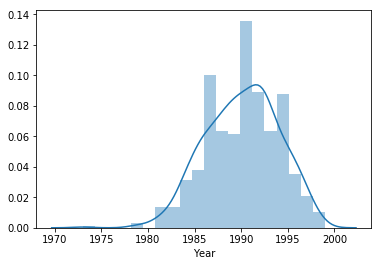

In [57]:
sns.distplot(worldcup.Year)
plt.show()

In [76]:
nations = worldcup[['Caps','Team','Age','Goals']].groupby(['Team']).sum()
nations['avg_age']=worldcup[['Team','Age']].groupby(['Team']).mean()
nations['players']=worldcup[['Team','Player']].groupby(['Team']).count()
nations.head()

,Caps,Age,Goals,avg_age,players
Team,,,,,
Argentina,840,660,172,28.695652,23
Australia,669,635,120,27.608696,23
Belgium,1024,624,143,27.130435,23
Brazil,670,644,124,28.000000,23
Colombia,719,634,92,27.565217,23


In [80]:
nations.sort_values('Caps', ascending= False).head(10)

,Caps,Age,Goals,avg_age,players
Team,,,,,
Mexico,1416,664,208,28.869565,23
Panama,1414,663,151,28.826087,23
Costa Rica,1163,669,116,29.086957,23
Belgium,1024,624,143,27.130435,23
Japan,1003,649,160,28.217391,23
Uruguay,955,636,131,27.652174,23
Spain,954,644,104,28.000000,23
Germany,928,614,158,26.695652,23
Croatia,910,631,114,27.434783,23


In [81]:
nations.sort_values('Goals', ascending= False).head(10)

,Caps,Age,Goals,avg_age,players
Team,,,,,
Mexico,1416,664,208,28.869565,23
Argentina,840,660,172,28.695652,23
Japan,1003,649,160,28.217391,23
Germany,928,614,158,26.695652,23
Panama,1414,663,151,28.826087,23
Belgium,1024,624,143,27.130435,23
Portugal,892,642,139,27.913043,23
Uruguay,955,636,131,27.652174,23
Brazil,670,644,124,28.000000,23


In [82]:
nations.sort_values('avg_age', ascending= False).head(10)

,Caps,Age,Goals,avg_age,players
Team,,,,,
Costa Rica,1163,669,116,29.086957,23
Mexico,1416,664,208,28.869565,23
Panama,1414,663,151,28.826087,23
Argentina,840,660,172,28.695652,23
Egypt,841,654,64,28.434783,23
Russia,640,650,55,28.260870,23
Japan,1003,649,160,28.217391,23
Saudi Arabia,772,647,90,28.130435,23
Iceland,905,647,79,28.130435,23


In [83]:
nations.sort_values('avg_age').head(10)

,Caps,Age,Goals,avg_age,players
Team,,,,,
Nigeria,573,587,56,25.521739,23
France,582,588,86,25.565217,23
England,465,588,57,25.565217,23
Tunisia,448,598,36,26.000000,23
Serbia,580,604,60,26.260870,23
Switzerland,842,612,96,26.608696,23
Denmark,594,612,63,26.608696,23
Iran,685,613,108,26.652174,23
Germany,928,614,158,26.695652,23


In [72]:
clubs = worldcup[['Caps','Club','Age','Goals']].groupby(['Club']).sum()
clubs['avg_age']=worldcup[['Club','Age']].groupby(['Club']).mean()
clubs['players']=worldcup[['Club','Player']].groupby(['Club']).count()
clubs.head()

,Caps,Age,Goals,avg_age,players
Club,,,,,
1. FC Köln,64,56,10,28.0,2
1899 Hoffenheim,41,52,11,26.0,2
ADO Den Haag,6,22,0,22.0,1
AEK Athens,73,33,8,33.0,1
AZ,37,24,4,24.0,1


In [73]:
clubs.sort_values('Caps', ascending= False).head(10)

,Caps,Age,Goals,avg_age,players
Club,,,,,
Barcelona,907,394,186,28.142857,14
Real Madrid,807,408,138,27.200000,15
Manchester City,630,430,112,26.875000,16
Juventus,593,318,97,28.909091,11
Tottenham Hotspur,591,317,76,26.416667,12
Bayern Munich,553,296,123,26.909091,11
Paris Saint-Germain,463,309,134,25.750000,12
Chelsea,446,310,79,28.181818,11
Manchester United,426,290,70,26.363636,11


In [74]:
clubs.sort_values('Goals', ascending= False).head(10)

,Caps,Age,Goals,avg_age,players
Club,,,,,
Barcelona,907,394,186,28.142857,14
Real Madrid,807,408,138,27.200000,15
Paris Saint-Germain,463,309,134,25.750000,12
Bayern Munich,553,296,123,26.909091,11
Manchester City,630,430,112,26.875000,16
Juventus,593,318,97,28.909091,11
Chelsea,446,310,79,28.181818,11
Tottenham Hotspur,591,317,76,26.416667,12
Manchester United,426,290,70,26.363636,11


In [79]:
clubs.sort_values('players', ascending= False).head(10)

,Caps,Age,Goals,avg_age,players
Club,,,,,
Manchester City,630,430,112,26.875000,16
Real Madrid,807,408,138,27.200000,15
Barcelona,907,394,186,28.142857,14
Paris Saint-Germain,463,309,134,25.750000,12
Tottenham Hotspur,591,317,76,26.416667,12
Bayern Munich,553,296,123,26.909091,11
Juventus,593,318,97,28.909091,11
Chelsea,446,310,79,28.181818,11
Manchester United,426,290,70,26.363636,11


In [77]:
clubs.sort_values('avg_age', ascending= False).head(10)

,Caps,Age,Goals,avg_age,players
Club,,,,,
Melbourne City,1,19,0,19.0,1
Eupen,9,19,0,19.0,1
Hellas Verona,2,20,0,20.0,1
Lille,13,20,0,20.0,1
Norrköping,2,20,0,20.0,1
Nice,4,20,0,20.0,1
Nantes,4,21,0,21.0,1
Deportivo Fabril,10,21,2,21.0,1
Málaga,15,21,1,21.0,1


In [85]:
groups = worldcup[['Caps','Group','Age','Goals']].groupby(['Group']).sum()
groups['avg_age']=worldcup[['Group','Age']].groupby(['Group']).mean()
groups['players']=worldcup[['Group','Player']].groupby(['Group']).count()
groups.head()

,Caps,Age,Goals,avg_age,players
Group,,,,,
A,3208,2587,340,28.119565,92
B,3067,2515,408,27.336957,92
C,2614,2454,364,26.673913,92
D,3228,2525,421,27.445652,92
E,3255,2529,396,27.489130,92


In [89]:
groups.sort_values('Caps', ascending= False).head(8)

,Caps,Age,Goals,avg_age,players
Group,,,,,
F,3691,2542,516,27.630435,92
G,3351,2473,387,26.880435,92
E,3255,2529,396,27.489130,92
D,3228,2525,421,27.445652,92
A,3208,2587,340,28.119565,92
H,3094,2538,443,27.586957,92
B,3067,2515,408,27.336957,92
C,2614,2454,364,26.673913,92


In [88]:
groups.sort_values('avg_age', ascending= False).head(8)

,Caps,Age,Goals,avg_age,players
Group,,,,,
A,3208,2587,340,28.119565,92
F,3691,2542,516,27.630435,92
H,3094,2538,443,27.586957,92
E,3255,2529,396,27.489130,92
D,3228,2525,421,27.445652,92
B,3067,2515,408,27.336957,92
G,3351,2473,387,26.880435,92
C,2614,2454,364,26.673913,92


In [90]:
groups.sort_values('Goals', ascending= False).head(8)

,Caps,Age,Goals,avg_age,players
Group,,,,,
F,3691,2542,516,27.630435,92
H,3094,2538,443,27.586957,92
D,3228,2525,421,27.445652,92
B,3067,2515,408,27.336957,92
E,3255,2529,396,27.489130,92
G,3351,2473,387,26.880435,92
C,2614,2454,364,26.673913,92
A,3208,2587,340,28.119565,92


In [95]:
grouping = worldcup[['Team','Group']].groupby(['Group','Team']).count()

grouping.head(32)

Empty DataFrame
Columns: []
Index: [(A, Egypt), (A, Russia), (A, Saudi Arabia), (A, Uruguay), (B, Iran), (B, Morocco), (B, Portugal), (B, Spain), (C, Australia), (C, Denmark), (C, France), (C, Peru), (D, Argentina), (D, Croatia), (D, Iceland), (D, Nigeria), (E, Brazil), (E, Costa Rica), (E, Serbia), (E, Switzerland), (F, Germany), (F, Mexico), (F, South Korea), (F, Sweden), (G, Belgium), (G, England), (G, Panama), (G, Tunisia), (H, Colombia), (H, Japan), (H, Poland), (H, Senegal)]

In [84]:
271/736

0.36820652173913043

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

I went to Kaggle and found two datasets that I was interested of looking into and potentially merging. My main data set was about the Players that went to the 2018 World Cup. My second dataset was a FIFA 2018 Dataset. I first took a quick look at the Players Dataset and then attempted to merge on the FIFA 2018 Dataset. However, this proved to be difficult as names didn't align between datasets specially for South Korean,Brazilian and Portuguese players. In total 271 Players weren't aligning well of the 736 Players, which is 37% of the Players. I then decided to take a deeper dive into the World Cup Players dataset. For which I found interesting stats around the National Teams and Clubs. 


2.  What was the most challenging part of what you did?

The most challenging part of what I did was transforming the Date of Birth of the players that was in a string to a Datatime Value and then created Columns for each value (Year, Month and Day). The second most challenging part was creating separate datasets for National Teams and Clubs.

3.  What was the most interesting thing you learned?

The most interesting thing I learnt today was how to transform a dataset using the group by function in order to create secondary datasets.

From the dataset itself, I learnt the following interesting things:

*   Manchester City was the team that contributed the most players to the 2018 World Cup.
*   Barcelona was the team that contributed the most experience (Total Caps) as well as Goal Scoring Skills (Goals) to the World Cup.
* France who won the World Cup had the second youngest Team.



4.  What area would you like to explore with more time?

I would have wanted to be able to clean up the 271 players and been able to calculate which National Team according to FIFA 18 data was the most valuable National Team among other stats.



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.